***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-2.1)** From coarse-to-Fine slowly decrease the dimension. i.e. 32D>16D>8D (Coarse>Medium>FINE), While keeping the primary capsule dimension same as original ($P_{capsule} = 8D$). Training with $L_{cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD_2\Training_and_Analysis\3_CIFAR-10
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('MOD_2/3_CIFAR_10/HD_CapsNet/TD_W_C_loss')

FOLDER CREATED =  ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/TD_W_C_loss


# Import Dataset : CIFAR-10

In [5]:
dataset = datasets.CIFAR10(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR10(version = 'reduce') # importing CIFAR10 Dataset

CIFAR-10 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [9]:
coarse_to_medium_array = np.zeros(shape=[number_of_classes_c,number_of_classes_m], dtype=np.int32)
medium_to_fine_array = np.zeros(shape=[number_of_classes_m,number_of_classes_f], dtype=np.int32)

c_id = np.argmax(dataset['y_train_coarse'],1)

m_id = np.argmax(dataset['y_train_medium'],1)

f_id = np.argmax(dataset['y_train_fine'],1)

for x in range(len(dataset['y_test_medium'])):
    coarse_to_medium_array[c_id[x]][m_id[x]] = 1
    
for x in range(len(dataset['y_test_fine'])):
    medium_to_fine_array[m_id[x]][f_id[x]] = 1

Matrix_coarse_to_medium_OneHot = tf.constant(coarse_to_medium_array, dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(medium_to_fine_array, dtype=tf.float32)

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,tree: Tree,C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=7)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=10)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Model Architecture

In [11]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = 2
    no_medium_class = 7
    no_fine_class = 10

    PCap_n_dims = 8

    SCap_f_dims = 8
    SCap_m_dims = 16
    SCap_c_dims = 32


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    reshapec = keras.layers.Reshape((int((tf.reduce_prod(x.shape[1:]).numpy())/PCap_n_dims), 
                                     PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(models.squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = models.SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(p_caps)
    
    ## Layer Secondary Capsule: For medium level
    s_caps_m = models.SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_c)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = models.SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(s_caps_m)

    pred_c = models.LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = models.LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = models.LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw'],
                              dataset['tree']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [12]:
model = get_compiled_model()

In [13]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.cast (TFOpLambda)           (None,)              0           ['tf.math.argmax_4[0][0]']       
                                                                                                  
 tf.reshape (TFOpLambda)        (None, 1)            0           ['tf.math.reduce_sum_2[0][0]']   
                                                                                                  
 tf.math.argmax (TFOpLambda)    (None,)              0           ['prediction_coarse[0][0]']      
                                                                                                  
 tf.math.argmax_1 (TFOpLambda)  (None,)              0           ['prediction_medium[0][0]']      
                                                                                                  
 tf.math.argmax_5 (TFOpLambda)  (None,)              0           ['input_ym[0][0]']               
          

 da)                                                                                              
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
                                                                                                  
 tf.math.maximum_4 (TFOpLambda)  (None, 10)          0           ['tf.math.subtract_10[0][0]']    
                                                                                                  
 tf.math.subtract_12 (TFOpLambd  (None, 10)          0           ['input_yf[0][0]']               
 a)                                                                                               
                                                                                                  
 tf.math.m

                                                                                                  
 tf.math.multiply_4 (TFOpLambda  (None,)             0           ['tf.math.abs_2[0][0]',          
 )                                                                'tf.math.abs[0][0]']            
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 10)           0           ['tf.math.multiply_16[0][0]',    
                                                                  'tf.math.multiply_18[0][0]']    
                                                                                                  
 tf.math.abs_3 (TFOpLambda)     (None,)              0           ['tf.math.subtract_3[0][0]']     
                                                                                                  
 tf.math.abs_1 (TFOpLambda)     (None,)              0           ['tf.math.subtract_1[0][0]']     
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/epoch-best.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = models.LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'],
                                            dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    model.save_weights(model_save_dir)

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.2867 - prediction_coarse_accuracy: 0.8618 - prediction_medium_accuracy: 0.4311 - prediction_fine_accuracy: 0.2490
  • Coarse Accuracy = 86.18% | Val_Accuracy = 88.40% | LossWeight = 0.15 
  • Medium Accuracy = 43.11% | Val_Accuracy = 56.84% | LossWeight = 0.43 
  • Fine   Accuracy = 24.90% | Val_Accuracy = 37.12% | LossWeight = 0.42 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.37120, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 66s 70ms/step - loss: 0.2867 - prediction_coarse_accuracy: 0.8618 - prediction_medium_accuracy: 0.4311 - prediction_fine_accuracy: 0.2490 - val_loss: 0.1921 - val_prediction_coarse_accuracy: 0.8840 - val_prediction_medium_accuracy: 0.5684 - val_prediction_fine_accuracy: 0.3712 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.1555 - prediction_coarse_accuracy

780/781 [============================>.] - ETA: 0s - loss: 0.0779 - prediction_coarse_accuracy: 0.9658 - prediction_medium_accuracy: 0.8826 - prediction_fine_accuracy: 0.8207
  • Coarse Accuracy = 96.57% | Val_Accuracy = 97.52% | LossWeight = 0.16 
  • Medium Accuracy = 88.26% | Val_Accuracy = 87.28% | LossWeight = 0.39 
  • Fine   Accuracy = 82.07% | Val_Accuracy = 82.04% | LossWeight = 0.45 

Epoch 9: val_prediction_fine_accuracy improved from 0.80500 to 0.82040, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 41s 53ms/step - loss: 0.0779 - prediction_coarse_accuracy: 0.9657 - prediction_medium_accuracy: 0.8826 - prediction_fine_accuracy: 0.8207 - val_loss: 0.0529 - val_prediction_coarse_accuracy: 0.9752 - val_prediction_medium_accuracy: 0.8728 - val_prediction_fine_accuracy: 0.8204 - lr: 0.0010
Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.0739 - prediction_coarse_accuracy: 0.9672

Epoch 18/100
781/781 [==============================] - ETA: 0s - loss: 0.0566 - prediction_coarse_accuracy: 0.9787 - prediction_medium_accuracy: 0.9376 - prediction_fine_accuracy: 0.9085
  • Coarse Accuracy = 97.87% | Val_Accuracy = 98.22% | LossWeight = 0.19 
  • Medium Accuracy = 93.76% | Val_Accuracy = 91.01% | LossWeight = 0.39 
  • Fine   Accuracy = 90.85% | Val_Accuracy = 87.18% | LossWeight = 0.43 

Epoch 18: val_prediction_fine_accuracy improved from 0.87070 to 0.87180, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 44s 56ms/step - loss: 0.0566 - prediction_coarse_accuracy: 0.9787 - prediction_medium_accuracy: 0.9376 - prediction_fine_accuracy: 0.9085 - val_loss: 0.0382 - val_prediction_coarse_accuracy: 0.9822 - val_prediction_medium_accuracy: 0.9101 - val_prediction_fine_accuracy: 0.8718 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.0553 - prediction_coars

Epoch 27/100
781/781 [==============================] - ETA: 0s - loss: 0.0502 - prediction_coarse_accuracy: 0.9816 - prediction_medium_accuracy: 0.9552 - prediction_fine_accuracy: 0.9393
  • Coarse Accuracy = 98.16% | Val_Accuracy = 98.22% | LossWeight = 0.22 
  • Medium Accuracy = 95.52% | Val_Accuracy = 91.96% | LossWeight = 0.38 
  • Fine   Accuracy = 93.93% | Val_Accuracy = 88.76% | LossWeight = 0.39 

Epoch 27: val_prediction_fine_accuracy improved from 0.88250 to 0.88760, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 41s 53ms/step - loss: 0.0502 - prediction_coarse_accuracy: 0.9816 - prediction_medium_accuracy: 0.9552 - prediction_fine_accuracy: 0.9393 - val_loss: 0.0347 - val_prediction_coarse_accuracy: 0.9822 - val_prediction_medium_accuracy: 0.9196 - val_prediction_fine_accuracy: 0.8876 - lr: 4.1812e-04
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.0503 - prediction_coars

781/781 [==============================] - ETA: 0s - loss: 0.0480 - prediction_coarse_accuracy: 0.9843 - prediction_medium_accuracy: 0.9615 - prediction_fine_accuracy: 0.9511
  • Coarse Accuracy = 98.43% | Val_Accuracy = 98.52% | LossWeight = 0.23 
  • Medium Accuracy = 96.15% | Val_Accuracy = 92.55% | LossWeight = 0.39 
  • Fine   Accuracy = 95.11% | Val_Accuracy = 89.07% | LossWeight = 0.38 

Epoch 36: val_prediction_fine_accuracy did not improve from 0.89120
781/781 [==============================] - 42s 54ms/step - loss: 0.0480 - prediction_coarse_accuracy: 0.9843 - prediction_medium_accuracy: 0.9615 - prediction_fine_accuracy: 0.9511 - val_loss: 0.0327 - val_prediction_coarse_accuracy: 0.9852 - val_prediction_medium_accuracy: 0.9255 - val_prediction_fine_accuracy: 0.8907 - lr: 2.6352e-04
Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.0483 - prediction_coarse_accuracy: 0.9829 - prediction_medium_accuracy: 0.9596 - prediction_fine_accuracy: 0.9507
  • Coar

780/781 [============================>.] - ETA: 0s - loss: 0.0468 - prediction_coarse_accuracy: 0.9837 - prediction_medium_accuracy: 0.9636 - prediction_fine_accuracy: 0.9551
  • Coarse Accuracy = 98.38% | Val_Accuracy = 98.67% | LossWeight = 0.25 
  • Medium Accuracy = 96.36% | Val_Accuracy = 92.77% | LossWeight = 0.39 
  • Fine   Accuracy = 95.52% | Val_Accuracy = 89.79% | LossWeight = 0.36 

Epoch 45: val_prediction_fine_accuracy improved from 0.89590 to 0.89790, saving model to ../../logs/MOD_2/3_CIFAR_10/HD_CapsNet/TD_W_C_loss\epoch-best.h5
781/781 [==============================] - 41s 53ms/step - loss: 0.0468 - prediction_coarse_accuracy: 0.9838 - prediction_medium_accuracy: 0.9636 - prediction_fine_accuracy: 0.9552 - val_loss: 0.0311 - val_prediction_coarse_accuracy: 0.9867 - val_prediction_medium_accuracy: 0.9277 - val_prediction_fine_accuracy: 0.8979 - lr: 1.6608e-04
Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.0471 - prediction_coarse_accuracy: 0

781/781 [==============================] - ETA: 0s - loss: 0.0469 - prediction_coarse_accuracy: 0.9839 - prediction_medium_accuracy: 0.9640 - prediction_fine_accuracy: 0.9572
  • Coarse Accuracy = 98.39% | Val_Accuracy = 98.71% | LossWeight = 0.25 
  • Medium Accuracy = 96.40% | Val_Accuracy = 93.04% | LossWeight = 0.40 
  • Fine   Accuracy = 95.72% | Val_Accuracy = 89.91% | LossWeight = 0.35 

Epoch 54: val_prediction_fine_accuracy did not improve from 0.90100
781/781 [==============================] - 40s 52ms/step - loss: 0.0469 - prediction_coarse_accuracy: 0.9839 - prediction_medium_accuracy: 0.9640 - prediction_fine_accuracy: 0.9572 - val_loss: 0.0303 - val_prediction_coarse_accuracy: 0.9871 - val_prediction_medium_accuracy: 0.9304 - val_prediction_fine_accuracy: 0.8991 - lr: 1.0467e-04
Epoch 55/100
780/781 [============================>.] - ETA: 0s - loss: 0.0469 - prediction_coarse_accuracy: 0.9850 - prediction_medium_accuracy: 0.9652 - prediction_fine_accuracy: 0.9591
  • Coar

781/781 [==============================] - 74s 94ms/step - loss: 0.0464 - prediction_coarse_accuracy: 0.9840 - prediction_medium_accuracy: 0.9649 - prediction_fine_accuracy: 0.9586 - val_loss: 0.0297 - val_prediction_coarse_accuracy: 0.9871 - val_prediction_medium_accuracy: 0.9330 - val_prediction_fine_accuracy: 0.9011 - lr: 6.5971e-05
Epoch 64/100
781/781 [==============================] - ETA: 0s - loss: 0.0460 - prediction_coarse_accuracy: 0.9842 - prediction_medium_accuracy: 0.9644 - prediction_fine_accuracy: 0.9589
  • Coarse Accuracy = 98.42% | Val_Accuracy = 98.73% | LossWeight = 0.25 
  • Medium Accuracy = 96.44% | Val_Accuracy = 93.38% | LossWeight = 0.40 
  • Fine   Accuracy = 95.89% | Val_Accuracy = 90.15% | LossWeight = 0.35 

Epoch 64: val_prediction_fine_accuracy did not improve from 0.90270
781/781 [==============================] - 77s 98ms/step - loss: 0.0460 - prediction_coarse_accuracy: 0.9842 - prediction_medium_accuracy: 0.9644 - prediction_fine_accuracy: 0.9589 - 

780/781 [============================>.] - ETA: 0s - loss: 0.0458 - prediction_coarse_accuracy: 0.9844 - prediction_medium_accuracy: 0.9670 - prediction_fine_accuracy: 0.9608
  • Coarse Accuracy = 98.44% | Val_Accuracy = 98.69% | LossWeight = 0.26 
  • Medium Accuracy = 96.70% | Val_Accuracy = 93.21% | LossWeight = 0.39 
  • Fine   Accuracy = 96.08% | Val_Accuracy = 90.10% | LossWeight = 0.35 

Epoch 73: val_prediction_fine_accuracy did not improve from 0.90270
781/781 [==============================] - 76s 97ms/step - loss: 0.0458 - prediction_coarse_accuracy: 0.9844 - prediction_medium_accuracy: 0.9670 - prediction_fine_accuracy: 0.9608 - val_loss: 0.0297 - val_prediction_coarse_accuracy: 0.9869 - val_prediction_medium_accuracy: 0.9321 - val_prediction_fine_accuracy: 0.9010 - lr: 3.9499e-05
Epoch 74/100
781/781 [==============================] - ETA: 0s - loss: 0.0460 - prediction_coarse_accuracy: 0.9845 - prediction_medium_accuracy: 0.9651 - prediction_fine_accuracy: 0.9588
  • Coar

781/781 [==============================] - 77s 99ms/step - loss: 0.0456 - prediction_coarse_accuracy: 0.9853 - prediction_medium_accuracy: 0.9662 - prediction_fine_accuracy: 0.9594 - val_loss: 0.0294 - val_prediction_coarse_accuracy: 0.9872 - val_prediction_medium_accuracy: 0.9331 - val_prediction_fine_accuracy: 0.9014 - lr: 2.4894e-05
Epoch 83/100
781/781 [==============================] - ETA: 0s - loss: 0.0457 - prediction_coarse_accuracy: 0.9846 - prediction_medium_accuracy: 0.9656 - prediction_fine_accuracy: 0.9599
  • Coarse Accuracy = 98.46% | Val_Accuracy = 98.74% | LossWeight = 0.25 
  • Medium Accuracy = 96.56% | Val_Accuracy = 93.46% | LossWeight = 0.40 
  • Fine   Accuracy = 95.99% | Val_Accuracy = 90.30% | LossWeight = 0.35 

Epoch 83: val_prediction_fine_accuracy did not improve from 0.90380
781/781 [==============================] - 72s 92ms/step - loss: 0.0457 - prediction_coarse_accuracy: 0.9846 - prediction_medium_accuracy: 0.9656 - prediction_fine_accuracy: 0.9599 - 

781/781 [==============================] - ETA: 0s - loss: 0.0459 - prediction_coarse_accuracy: 0.9850 - prediction_medium_accuracy: 0.9656 - prediction_fine_accuracy: 0.9602
  • Coarse Accuracy = 98.50% | Val_Accuracy = 98.77% | LossWeight = 0.25 
  • Medium Accuracy = 96.56% | Val_Accuracy = 93.39% | LossWeight = 0.40 
  • Fine   Accuracy = 96.02% | Val_Accuracy = 90.21% | LossWeight = 0.35 

Epoch 92: val_prediction_fine_accuracy did not improve from 0.90380
781/781 [==============================] - 91s 116ms/step - loss: 0.0459 - prediction_coarse_accuracy: 0.9850 - prediction_medium_accuracy: 0.9656 - prediction_fine_accuracy: 0.9602 - val_loss: 0.0294 - val_prediction_coarse_accuracy: 0.9877 - val_prediction_medium_accuracy: 0.9339 - val_prediction_fine_accuracy: 0.9021 - lr: 1.4905e-05
Epoch 93/100
781/781 [==============================] - ETA: 0s - loss: 0.0455 - prediction_coarse_accuracy: 0.9852 - prediction_medium_accuracy: 0.9664 - prediction_fine_accuracy: 0.9607
  • Coa

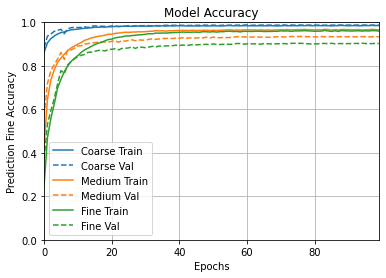

In [17]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

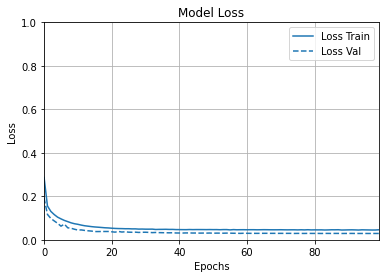

In [18]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])

except:
    print('Trained model weights loaded')

## Model Analysis

In [19]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 8s 18ms/step - loss: 0.0480 - prediction_coarse_loss: 0.0104 - prediction_medium_loss: 0.0490 - prediction_fine_loss: 0.0728 - prediction_coarse_accuracy: 0.9876 - prediction_medium_accuracy: 0.9336 - prediction_fine_accuracy: 0.9026
1. loss ==> 0.048043593764305115
2. prediction_coarse_loss ==> 0.010416966862976551
3. prediction_medium_loss ==> 0.04903431236743927
4. prediction_fine_loss ==> 0.07275362312793732
5. prediction_coarse_accuracy ==> 0.9876000285148621
6. prediction_medium_accuracy ==> 0.9336000084877014
7. prediction_fine_accuracy ==> 0.9025999903678894
313/313 [==============================] - 4s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

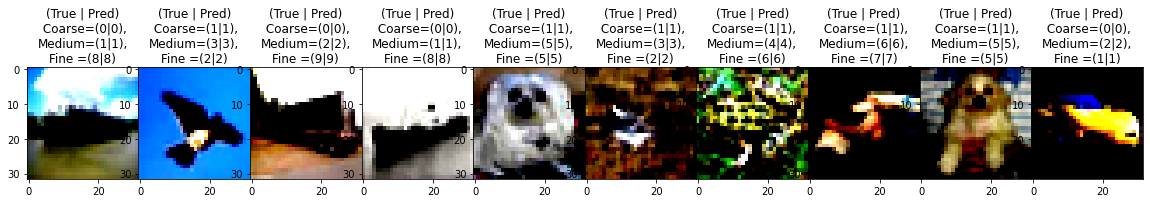

In [20]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[3942   58]
 [  66 5934]]

  • MEDIUM LEVEL 
[[ 931   21   16   17    3    5    7]
 [  34  934   23    2    3    1    3]
 [  12   15 1964    2    3    3    1]
 [  26    2    2  857   22   59   32]
 [   1    0    2   14  953   27    3]
 [   8    6    9   39   39 1828   71]
 [  10    1    2   33   20   65 1869]]

  • FINE LEVEL 
[[931   9  18   6   3   0   3   4  21   5]
 [  3 961   1   2   0   0   3   0   2  28]
 [ 27   1 866  36  18  19  22   9   2   0]
 [  7   1  28 798  23  91  31  12   4   5]
 [  5   2  29  18 904  10  18  13   1   0]
 [  4   0  16 109  19 818  14  18   1   1]
 [  1   0  15  21   4   3 954   0   0   2]
 [  7   0  11  15  18  14   3 931   0   1]
 [ 34   9   3   2   0   0   2   1 936  13]
 [ 10  42   1   1   0   1   2   1  15 927]]

  • Classification Report 


  • COARSE LEVEL 


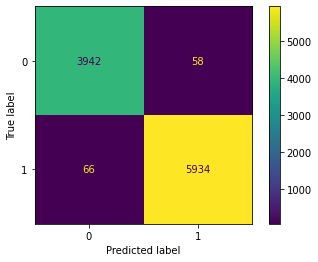

              precision    recall  f1-score   support

           0    0.98353   0.98550   0.98452      4000
           1    0.99032   0.98900   0.98966      6000

    accuracy                        0.98760     10000
   macro avg    0.98693   0.98725   0.98709     10000
weighted avg    0.98761   0.98760   0.98760     10000


  • MEDIUM LEVEL 


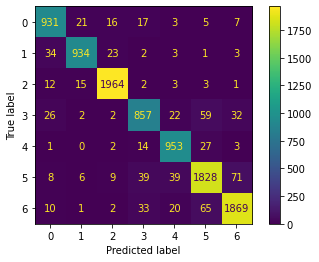

              precision    recall  f1-score   support

           0    0.91096   0.93100   0.92087      1000
           1    0.95403   0.93400   0.94391      1000
           2    0.97324   0.98200   0.97760      2000
           3    0.88900   0.85700   0.87271      1000
           4    0.91371   0.95300   0.93294      1000
           5    0.91952   0.91400   0.91675      2000
           6    0.94109   0.93450   0.93778      2000

    accuracy                        0.93360     10000
   macro avg    0.92879   0.92936   0.92894     10000
weighted avg    0.93354   0.93360   0.93347     10000


  • FINE LEVEL 


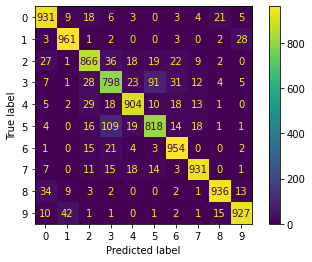

              precision    recall  f1-score   support

           0    0.90476   0.93100   0.91769      1000
           1    0.93756   0.96100   0.94914      1000
           2    0.87652   0.86600   0.87123      1000
           3    0.79167   0.79800   0.79482      1000
           4    0.91405   0.90400   0.90900      1000
           5    0.85565   0.81800   0.83640      1000
           6    0.90684   0.95400   0.92982      1000
           7    0.94135   0.93100   0.93615      1000
           8    0.95316   0.93600   0.94450      1000
           9    0.94399   0.92700   0.93542      1000

    accuracy                        0.90260     10000
   macro avg    0.90256   0.90260   0.90242     10000
weighted avg    0.90256   0.90260   0.90242     10000



In [21]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [22]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9409016666666666 
Hierarchical Recall = 0.9429666666666666 
Hierarchical F1-Score = 0.9417630952380954 
Consistency =  0.9894 
Exact Match =  0.8985
